In [2]:
import yfinance as yf
import pandas as pd

In [3]:
def backtest_strategy(ticker, start_date, end_date, buy_in_percentage, sell_out_percentage, ema_range, buy_differential, sell_differential):
    # Fetch the historical stock data from the Yahoo API
    data = yf.download(ticker, start=start_date, end=end_date)

    # Calculate the exponential moving average of the stock price over the specified range
    data['EMA'] = data['Adj Close'].ewm(span=ema_range, adjust=False).mean()

    # Initialize variables to keep track of cash and equity holdings
    cash = 1.0  # Start with $1 of cash
    shares = 0  # Start with $0 of equity
    equity = 0.0  # Start with $0 of equity
    last_action = 'nothing'
    starting_index_value = data['Adj Close'][ema_range]


    output_list = []
    # Loop through each day of the backtesting period
    for i in range(ema_range, len(data)):
        record_date = data.index[i]
        equity = shares * data['Adj Close'][i]

        spy_index = data['Adj Close'][i]
        spy_ema = data['EMA'][i]

        # Check if the stock price is above the EMA by the specified differential
        if spy_index > (spy_ema * (1 + buy_differential)):
            # Calculate the amount of cash to use for buying based on the percentage specified
            buy_amount = cash * buy_in_percentage

            # Calculate the number of shares to buy based on the buy amount and current stock price
            buy_shares = buy_amount / data['Adj Close'][i]

            # Subtract the buy amount from cash and add the buy value to equity
            cash -= buy_amount
            shares += buy_shares
            equity = shares * data['Adj Close'][i]
            last_action = 'bought'


        # Check if the stock price is below the EMA by the specified differential
        elif spy_index < (spy_ema * (1 - sell_differential)):
            # Calculate the amount of equity to sell based on the percentage specified
            sell_amount = equity * sell_out_percentage

            # Calculate the sell amount based on the number of shares to sell and current stock price
            sell_shares = sell_amount / data['Adj Close'][i]

            # Subtract the sell amount from equity and add it to cash
            cash += sell_amount
            shares -= sell_shares
            equity = shares * data['Adj Close'][i]
            last_action = 'sold'
            

        #print(record_date,'cash:',cash,'equity:',equity,'total value:',cash+equity,last_action,spy_index,spy_ema)
        output_list.append((record_date,cash/(cash+equity),equity/(cash+equity),cash+equity,last_action,spy_index/starting_index_value,spy_ema/starting_index_value))
    
    output_df = pd.DataFrame([{'record_date': r[0], 'cash_percentage': r[1], 'equity_percentage': r[2], 'total_value': r[3], 'last_action': r[4], 'relative_spy_index': r[5], 'relative_spy_ema': r[6]} for r in output_list])
    return output_df
        


[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='record_date'>

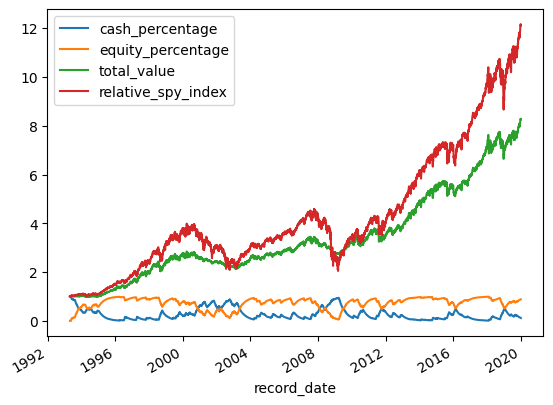

In [8]:
df = backtest_strategy('SPY','1990-01-01','2020-01-01',0.01,0.01,60,0.01,0.01)
df.plot(x = 'record_date', y=['cash_percentage','equity_percentage','total_value','relative_spy_index'])